In [21]:
import pandas as pd
import pylab as pl
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
import scipy.stats as ss
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV  
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc

%matplotlib inline

In [2]:
data = pd.read_csv("soybean-large_data.csv")
data.columns

Index(['name', 'date', 'plant-stand', 'precip', 'temp', 'hail', 'crop-hist',
       'area-damaged', 'severity', 'seed-tmt', 'germination', 'plant-growth',
       'leaves', 'leafspots-halo', 'leafspots-marg', 'leafspot-size',
       'leaf-shread', 'leaf-malf', 'leaf-mild', 'stem', 'lodging',
       'stem-cankers', 'canker-lesion', 'fruiting-bodies', 'external decay',
       'mycelium', 'int-discolor', 'sclerotia', 'fruit-pods', 'fruit spots',
       'seed', 'mold-growth', 'seed-discolor', 'seed-size', 'shriveling',
       'roots'],
      dtype='object')

In [3]:
data.tail()

,name,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,...,int-discolor,sclerotia,fruit-pods,fruit spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots
302,2-4-d-injury,?,?,?,?,?,?,?,?,?,...,?,?,?,?,?,?,?,?,?,?
303,herbicide-injury,1,1,?,0,?,1,0,?,?,...,?,?,3,?,?,?,?,?,?,1
304,herbicide-injury,0,1,?,0,?,0,3,?,?,...,?,?,3,?,?,?,?,?,?,1
305,herbicide-injury,1,1,?,0,?,0,0,?,?,...,?,?,3,?,?,?,?,?,?,1
306,herbicide-injury,1,1,?,0,?,1,3,?,?,...,?,?,3,?,?,?,?,?,?,1


In [4]:
data.describe()

,leaves
count,307.000000
mean,0.892508
std,0.310243
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [5]:
#надо почистить данные и заменить все ?  на nan
data = data.replace(to_replace=['?'], value = [np.nan])

In [6]:
data.isnull().sum()

name                0
date                1
plant-stand         8
precip             11
temp                7
hail               41
crop-hist           1
area-damaged        1
severity           41
seed-tmt           41
germination        36
plant-growth        1
leaves              0
leafspots-halo     25
leafspots-marg     25
leafspot-size      25
leaf-shread        26
leaf-malf          25
leaf-mild          30
stem                1
lodging            41
stem-cankers       11
canker-lesion      11
fruiting-bodies    35
external decay     11
mycelium           11
int-discolor       11
sclerotia          11
fruit-pods         25
fruit spots        35
seed               29
mold-growth        29
seed-discolor      35
seed-size          29
shriveling         35
roots               7
dtype: int64

In [7]:
#не будем заменять пустые значения на что-то, попробуем просто удалить
data_withoutNA = data.dropna()

In [8]:
#проверить наличие скоррелированных переменных в ваших данных
#для категориальных переменных используем коеф корреляции Крамера (функция взята с kaggle)

In [9]:
from scipy.stats import chi2_contingency


def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [10]:
rows= []

for var1 in data_withoutNA:
  col = []
  for var2 in data_withoutNA :
    cramers =cramers_V(data_withoutNA[var1], data_withoutNA[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_withoutNA.columns, index =data_withoutNA.columns)



df

,name,date,plant-stand,precip,temp,hail,crop-hist,area-damaged,severity,seed-tmt,...,int-discolor,sclerotia,fruit-pods,fruit spots,seed,mold-growth,seed-discolor,seed-size,shriveling,roots
name,1.00,0.17,0.27,0.52,0.30,0.18,0.06,0.22,0.39,0.08,...,1.00,1.00,0.81,0.70,0.69,0.68,0.55,0.40,0.38,0.30
date,0.17,1.00,0.10,0.04,0.08,0.02,0.02,0.04,0.10,0.05,...,0.04,0.03,0.22,0.09,0.03,0.00,0.05,0.03,0.07,0.03
plant-stand,0.27,0.10,0.98,0.03,0.06,0.00,0.02,0.05,0.04,0.01,...,0.04,0.02,0.13,0.04,0.01,0.00,0.03,0.00,0.00,0.02
precip,0.52,0.04,0.03,1.00,0.00,0.03,0.02,0.04,0.10,0.01,...,0.32,0.23,0.05,0.04,0.03,0.03,0.02,0.01,0.01,0.02
temp,0.30,0.08,0.06,0.00,1.00,0.01,0.03,0.04,0.10,0.01,...,0.02,0.03,0.14,0.10,0.01,0.01,0.01,0.02,0.01,0.01
hail,0.18,0.02,0.00,0.03,0.01,0.98,0.03,0.01,0.00,0.00,...,0.02,0.01,0.01,0.02,0.02,0.01,0.04,0.00,0.00,0.00
crop-hist,0.06,0.02,0.02,0.02,0.03,0.03,1.00,0.08,0.03,0.01,...,0.01,0.00,0.01,0.01,0.01,0.01,0.02,0.00,0.01,0.01
area-damaged,0.22,0.04,0.05,0.04,0.04,0.01,0.08,1.00,0.05,0.04,...,0.04,0.03,0.15,0.03,0.02,0.01,0.00,0.01,0.02,0.02
severity,0.39,0.10,0.04,0.10,0.10,0.00,0.03,0.05,1.00,0.00,...,0.04,0.03,0.21,0.18,0.03,0.03,0.08,0.01,0.01,0.01
seed-tmt,0.08,0.05,0.01,0.01,0.01,0.00,0.01,0.04,0.00,1.00,...,0.01,0.00,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.00


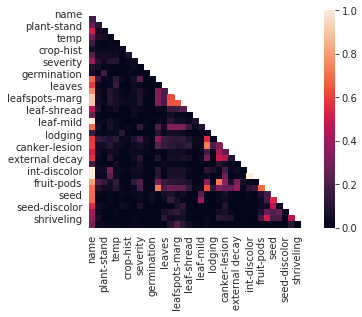

In [11]:
#визуализируем это
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True




with sns.axes_style("white"):
  ax = sns.heatmap(df, mask=mask,vmin=0., vmax=1, square=True)

plt.show()

In [13]:
#видно, что переменная name коррелирует почти со всеми фичами, кроме crop-hist, germination и seed-tmt, но удалять их не будем 
#также некоторые переменные коррелируют между собой, но тк мы будем использовать RandomForest, которому они не мешают, их удалять тоже не будем

In [ ]:
#2. Разделите ваш датасет на тестовую и тренировочную выборки в таком отношении, что бы
#все классы были представлены в обоих выборках и были стратифицированны (равное
#распределение классов, нужно указать доп. опцию в фунции train_test_split)

In [14]:
X = data_withoutNA.drop("name",axis=1)
y = data_withoutNA.name

In [16]:
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

In [27]:
#подбираем параметры для классификатора (как сказано ранее, будем использовать RandomForest)
parameters = {'max_depth':list(range(3,20))} 
clf = RandomForestClassifier(n_estimators=100, random_state=0)
grid_clf = GridSearchCV(estimator=clf, param_grid=parameters, cv=3, n_jobs=-1)
grid_clf.fit(X_train, y_train)
print('Лучшие параметры:', grid_clf.best_params_)
print(grid_clf.best_score_)

Лучшие параметры: {'max_depth': 9}
0.8988700564971751


In [28]:
best_rf = grid_clf.best_estimator_
best_rf.score(X_test,y_test)
y_pred = best_rf.predict(X_test)

# Оцените качество вашего классификатора используя известные вам метрики
print(metrics.classification_report(y_test, y_pred))

                        precision    recall  f1-score   support

   alternarialeaf-spot       0.69      0.85      0.76        13
           anthracnose       1.00      1.00      1.00         7
      bacterial-blight       1.00      1.00      1.00         3
     bacterial-pustule       1.00      1.00      1.00         3
            brown-spot       0.92      0.92      0.92        13
        brown-stem-rot       1.00      1.00      1.00         7
          charcoal-rot       1.00      1.00      1.00         3
 diaporthe-stem-canker       1.00      1.00      1.00         3
          downy-mildew       1.00      1.00      1.00         4
    frog-eye-leaf-spot       0.78      0.54      0.64        13
phyllosticta-leaf-spot       0.75      1.00      0.86         3
      phytophthora-rot       1.00      1.00      1.00         5
        powdery-mildew       1.00      1.00      1.00         3
     purple-seed-stain       1.00      1.00      1.00         4
  rhizoctonia-root-rot       1.00      

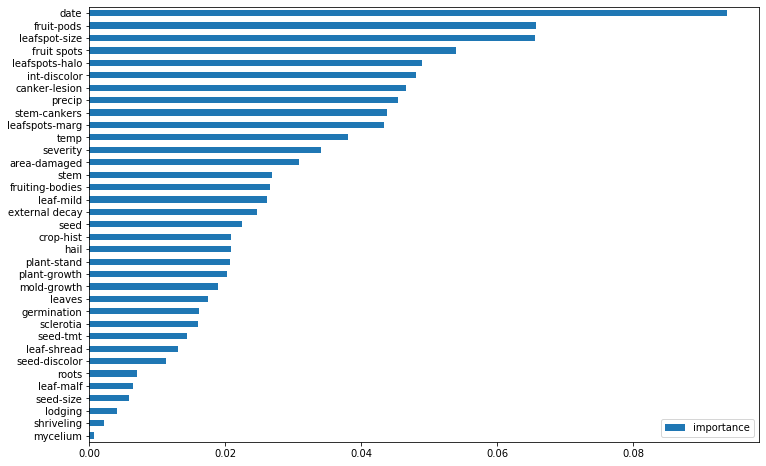

In [36]:
#визуализируем топ-3 важных признака. здравый смысл подсказывает, что date на самом деле не является важным 
#возможно его надо было дропнуть
imp =pd.DataFrame(best_rf.feature_importances_, index=X_test.columns, columns=['importance'])
imp.sort_values('importance').plot(kind='barh', figsize=(12, 8))
plt.show()
